#Spam Classifier

Source code for the Flask Application can be found [here](https://github.com/Pogayo/SpamClassifier).You will also find the link to a version hosted on heroku there.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import drive

In [3]:
drive.mount('./drive')

Mounted at ./drive


In [4]:
!cp "/content/drive/MyDrive/Year 4/Machine Learning/spam_or_not_spam.csv.zip" spam_or_not_spam.csv.zip
!unzip -q spam_or_not_spam.csv.zip

In [5]:
df=pd.read_csv("spam_or_not_spam.csv")

In [ ]:
df.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [6]:
df.describe()

,label
count,3000.000000
mean,0.166667
std,0.372740
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [77]:
df[df.label==1]

,email,label
2500,save up to NUMBER on life insurance why spend...,1
2501,NUMBER fight the risk of cancer URL NUMBER sli...,1
2502,NUMBER fight the risk of cancer URL NUMBER sli...,1
2503,adult club offers free membership instant acc...,1
2504,i thought you might like these NUMBER slim dow...,1
...,...,...
2995,abc s good morning america ranks it the NUMBE...,1
2996,hyperlink hyperlink hyperlink let mortgage le...,1
2997,thank you for shopping with us gifts for all ...,1
2998,the famous ebay marketing e course learn to s...,1


**If an email is spam - 1 if no, 0**

##Splitting the dataset

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df.groupby('label').describe().T

label                                      0                                                  1
email count                             2500                                                499
      unique                            2445                                                427
      top     url URL date not supplied URL   lowest rates available for term life insurance...
      freq                                10                                                  5

In [9]:
ham_size=df.groupby('label').describe().T.iloc[0,0]
spam_size=df.groupby('label').describe().T.iloc[0,1]
print(ham_size, spam_size)

2500 499


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


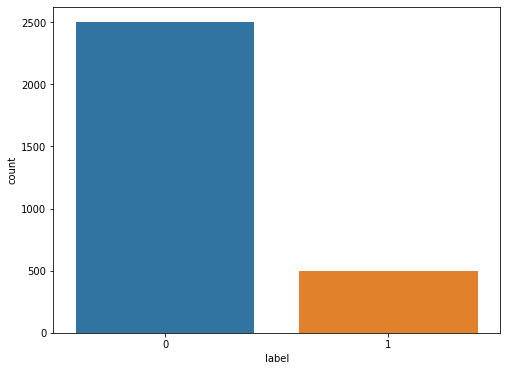

In [11]:
# Visualizing imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(df.label)

In [12]:
(spam_size/len(df))*100 # # Percentage of spam messages

16.633333333333333

This is an imbalanced dataset, so we should use a split strategy that takes this into account.

In [13]:
from keras.utils import to_categorical
X=df["email"]
y_encoded=to_categorical(df["label"]) #encoding the data- we wont use them though
y=df["label"]

In [14]:
X=X.apply(str) #making sure we are only dealing with strings

In [60]:
X_train, X_test, y_train, y_test=train_test_split(X, y,test_size=0.2, random_state=23, stratify=y) #using stratify to make the split proportional to the different labels

In [16]:
type(X)

pandas.core.series.Series

##Creating and saving the vocabulary

In [17]:
from keras.preprocessing.text import Tokenizer

# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(X.values)

print(t.word_counts)

OrderedDict([('date', 874), ('wed', 144), ('number', 33888), ('aug', 213), ('from', 3454), ('chris', 153), ('garrigues', 57), ('cwg', 22), ('dated', 29), ('numberfanumberd', 2), ('deepeddy', 30), ('com', 429), ('message', 854), ('id', 89), ('tmda', 51), ('vircio', 44), ('i', 9009), ('can', 2417), ('t', 3309), ('reproduce', 12), ('this', 5324), ('error', 278), ('for', 6760), ('me', 1107), ('it', 7059), ('is', 8007), ('very', 530), ('repeatable', 1), ('like', 1248), ('every', 412), ('time', 1294), ('without', 379), ('fail', 37), ('the', 28722), ('debug', 35), ('log', 216), ('of', 14264), ('pick', 97), ('happening', 16), ('exec', 15), ('inbox', 51), ('list', 2177), ('lbrace', 8), ('subject', 487), ('ftp', 25), ('rbrace', 8), ('sequence', 84), ('mercury', 7), ('ftoc', 59), ('pickmsgs', 1), ('hit', 142), ('marking', 6), ('hits', 32), ('tkerror', 1), ('syntax', 20), ('in', 9490), ('expression', 24), ('int', 52), ('note', 125), ('if', 2625), ('run', 414), ('command', 94), ('by', 2672), ('hand

Saving and loading the tokenizer for future inference

In [18]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
vocab=list(t.word_index.keys())
vocab_size=len(t.word_index)+1
max_length=max([len(s.split(" ")) for s in X])
print("Maximum length: ", max_length)
print("Vocabulary size:", vocab_size)

Maximum length:  13305
Vocabulary size: 33674


In [ ]:
vocab[:20]

['number',
 'the',
 'to',
 'and',
 'of',
 'a',
 'in',
 'i',
 'url',
 'is',
 'that',
 'you',
 'it',
 'for',
 'this',
 'on',
 's',
 'with',
 'be',
 'have']

In [20]:
def save_vocab(words, filename):
  data = '\n'.join(words)
  file = open(filename, 'w')
  file.write(data)
  file.close()

save_vocab(vocab, 'vocab.txt')

In [21]:
def load_vocab(filename): # function to load the vocabulary from a file
  file = open(filename, 'r')
  text = file.read()# read all text
  vocab = text.split()
  vocab = list(set(vocab))
  file.close() # close the file
  return vocab


# load vocabulary
vocab_filename = 'vocab.txt'
vocab = load_vocab(vocab_filename)

## Generate word embeddings

In [22]:
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

In [23]:
#loading glove embeddings from Kaggle as I am running this on Google Colab - change according to your source
import os
os.environ['KAGGLE_USERNAME'] = "pogayo" # username from the json file - use yours
os.environ['KAGGLE_KEY'] = "#########" # key from the json file- use yours
!kaggle datasets download -d danielwillgeorge/glove6b100dtxt # api copied from kaggle

 98% 129M/131M [00:10<00:00, 15.3MB/s]
100% 131M/131M [00:10<00:00, 12.7MB/s]


In [24]:
!unzip -q glove6b100dtxt.zip

In [25]:
def create_embeddings_index(filename):
  embeddings_index = dict()
  f = open( filename )
  for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype= 'float32' )
    embeddings_index[word] = coefs
  f.close()
  return embeddings_index

In [26]:
def create_embedding_matrix(tokenizer, embeddings_index):
  vocab_size=len(tokenizer.word_index)+1
  embedding_matrix = zeros((vocab_size, 100))
  for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
  return embedding_matrix



In [92]:
embeddings_index = create_embeddings_index('glove.6B.100d.txt')
print( ' Loaded %s word vectors. ' % len(embeddings_index))

 Loaded 400000 word vectors. 


In [94]:
embedding_matrix=create_embedding_matrix(t, embeddings_index)

In [ ]:
t.word_index

In [32]:
# Sequencing and padding on train and test sets 
max_len=50 #change accordingly
training_sequences = t.texts_to_sequences(X_train)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = 'post' )

testing_sequences = t.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = 'post')

####Save a shorter embeddings file with only the words in our training vocabulary

In [31]:
trimmed_embeddings=[]
f=open("embeddings.txt", 'w+')
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    line=word
    if embedding_vector is not None:
      embedding_string=[str(n) for n in embedding_vector]
      line=line+' '+' '.join(embedding_string)+"\n"
    f.write(line)
f.close()

######final function that puts everything together and outputs tokens ready for training/testing


In [27]:
def preprocess(data, tokenizer_filename, emb_filename, vocab_size= 33674,):

  """
  data is a pandas series object
  """
  # if (type(data)!='pandas.core.series.Series'):
  #   print("Please enter a series object")
  
  from keras.preprocessing.text import Tokenizer
  from numpy import asarray
  from numpy import zeros
  from keras.preprocessing.text import Tokenizer
  from keras.preprocessing.sequence import pad_sequences

  # loading
  with open(tokenizer_filename, 'rb') as handle:
    tokenizer = pickle.load(handle)

 
  # fit the tokenizer on the documents
  data=data.apply(str)
  
  embedding_index=create_embeddings_index(emb_filename)
  embedding_matrix=create_embedding_matrix(tokenizer, embeddings_index)
  
  max_len=50 #change accordingly
  test_sequences = tokenizer.texts_to_sequences(data)
  test_padded = pad_sequences(test_sequences, maxlen = max_len, padding = 'post' )
  
  return test_padded

In [81]:
test_tokens=preprocess(pd.Series(df.iloc[2999, 0]), "tokenizer.pickle", "embeddings.txt")

In [82]:
test_tokens

array([[33657, 33658, 33659, 18662, 18667, 18668, 18669,   500,    78,
            1,     1,     1, 13501,  9443,  1411, 33660, 33661, 18666,
        33662,   102,    68,    97, 13500,     9,   500,     1,     1,
            1, 33663, 33664,   821, 33665,   408,  9443, 33666,   355,
        33667, 33668, 33669, 33670,   497,   355, 33671,   254, 33672,
        33673, 18667, 18668, 18669,    78]], dtype=int32)

In [33]:
max_len

50

####Finally, create the embedding layer

In [34]:
#Create an embedding layer
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_len, trainable=False)

##Defining the Deep Neural Network

In [35]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Embedding

In [36]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2

In [70]:
#LSTM Spam detection architecture
model= Sequential()
model.add(e)
model.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model.add(LSTM(n_lstm, dropout=drop_lstm))
model.add(Dense(1, activation='sigmoid'))

In [38]:
initial_weights = model.get_weights(); #Will be useful in fine-tuning as we can compare different hyperparameters

In [71]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

##Model Training

In [40]:
from keras.callbacks import EarlyStopping

In [72]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           3367400   
_________________________________________________________________
lstm_6 (LSTM)                (None, 50, 20)            9680      
_________________________________________________________________
lstm_7 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 3,380,381
Trainable params: 12,981
Non-trainable params: 3,367,400
_________________________________________________________________


In [63]:
num_epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [73]:
model.fit(training_padded, y_train, epochs=num_epochs, validation_split=0.3,callbacks =[early_stop], verbose=2)

Epoch 1/10
53/53 - 3s - loss: 0.5035 - accuracy: 0.8226 - val_loss: 0.4184 - val_accuracy: 0.8500
Epoch 2/10
53/53 - 2s - loss: 0.4065 - accuracy: 0.8315 - val_loss: 0.2713 - val_accuracy: 0.8917
Epoch 3/10
53/53 - 2s - loss: 0.2500 - accuracy: 0.9060 - val_loss: 0.1881 - val_accuracy: 0.9264
Epoch 4/10
53/53 - 2s - loss: 0.1647 - accuracy: 0.9488 - val_loss: 0.1654 - val_accuracy: 0.9472
Epoch 5/10
53/53 - 2s - loss: 0.1585 - accuracy: 0.9440 - val_loss: 0.1348 - val_accuracy: 0.9444
Epoch 6/10
53/53 - 2s - loss: 0.1099 - accuracy: 0.9667 - val_loss: 0.1021 - val_accuracy: 0.9653
Epoch 7/10
53/53 - 2s - loss: 0.0865 - accuracy: 0.9726 - val_loss: 0.1109 - val_accuracy: 0.9653
Epoch 8/10
53/53 - 2s - loss: 0.0889 - accuracy: 0.9696 - val_loss: 0.1321 - val_accuracy: 0.9583


In [105]:
res=model.predict_classes(test_tokens)
res

array([[1]], dtype=int32)

In [106]:
res.flatten()

array([1], dtype=int32)

In [109]:
res.flatten()[0]

1

## Model evaluation & hyperparameter tuning

### First, we will test the default model that we created

In [ ]:
model.evaluate(testing_padded, y_test)

19/19 [==============================] - 0s 8ms/step - loss: 0.1961 - accuracy: 0.9321


[0.1960604190826416, 0.9321333765983582]

In [ ]:
def gen_model(embedding,n_neurons, drop_lstm ):
    model= Sequential()
    model.add(embedding)
    model.add(LSTM(n_neurons, dropout=drop_lstm, return_sequences=True))
    model.add(LSTM(n_neurons, dropout=drop_lstm, return_sequences=True))
    model.add(Dense(1, activation='sigmoid'))
    return model

###Then we will test early stopping so that we do not stop training too early

---



In [ ]:
def fit_lstm_early(X_train, y_train, embedding, n_lstm, drop_lstm, num_epochs, early_stop):
  train_acc=[]
  test_acc=[]
 
  for i in early_stop:
    # prepare model
    model= gen_model(embedding, n_lstm, drop_lstm )
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

    print("Early stopping patience: ", i)
    early_stop = EarlyStopping(monitor='val_loss', patience=i)
    model.fit(X_train, y_train, epochs=num_epochs, validation_split=0.3, callbacks =[early_stop], verbose=0)
		# evaluate model on train data
    train_acc.append(model.evaluate(X_train, y_train))
		# evaluate model on test data
    test_acc.append(model.evaluate(testing_padded, y_test))
    model.reset_states()
  history =pd.DataFrame(train_acc,columns=['train_loss','train_acc' ] )
  test_history =pd.DataFrame(test_acc,columns=['test_loss','test_acc' ] )
  history=history.join(test_history)  
  return history

In [ ]:
fit_lstm_early(training_padded, y_train, e,n_lstm, drop_lstm, 20,[2,3,4,5])

Early stopping patience:  2
19/19 [==============================] - 0s 9ms/step - loss: 0.1864 - accuracy: 0.9370
Early stopping patience:  3
19/19 [==============================] - 0s 9ms/step - loss: 0.1842 - accuracy: 0.9322
Early stopping patience:  4
19/19 [==============================] - 0s 9ms/step - loss: 0.1932 - accuracy: 0.9324
Early stopping patience:  5
19/19 [==============================] - 0s 9ms/step - loss: 0.2551 - accuracy: 0.9113


,train_loss,train_acc,test_loss,test_acc
0,0.147820,0.946325,0.186350,0.936967
1,0.113853,0.957492,0.184168,0.932200
2,0.117359,0.958608,0.193169,0.932367
3,0.161750,0.937034,0.255064,0.911267



Early stopping after 2 steps seems to have the highest test accuracy. So we will maintain it.
###Second, we will test the number of neurons in the lstm layers

In [ ]:
def fit_lstm_nodes(X_train, y_train, embedding, n_lstm, drop_lstm, num_epochs, early_stop):
  train_acc=[]
  test_acc=[]
  early_stopping = EarlyStopping(monitor='val_loss', patience=early_stop)

 
  for i in n_lstm:
    # prepare model

    model= Sequential()
    model.add(embedding)
    model.add(LSTM(i, dropout=drop_lstm, return_sequences=True))
    model.add(LSTM(i, dropout=drop_lstm, return_sequences=True))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

    print("Number of nodes: ", i)
    model.fit(X_train, y_train, epochs=num_epochs, validation_split=0.3, callbacks =[early_stopping], verbose=0)
		# evaluate model on train data
    train_acc.append(model.evaluate(X_train, y_train))
		# evaluate model on test data
    test_acc.append(model.evaluate(testing_padded, y_test))
    model.reset_states()
  history =pd.DataFrame(train_acc,columns=['train_loss','train_acc' ] )
  test_history =pd.DataFrame(test_acc,columns=['test_loss','test_acc' ] )
  history=history.join(test_history)  

  
  return history

In [ ]:
fit_lstm_nodes(training_padded, y_train, e,[10, 20, 30, 40], drop_lstm, 20,2)

Number of nodes:  10
19/19 [==============================] - 0s 7ms/step - loss: 0.2084 - accuracy: 0.9288
Number of nodes:  20
19/19 [==============================] - 0s 9ms/step - loss: 0.2090 - accuracy: 0.9288
Number of nodes:  30
19/19 [==============================] - 0s 10ms/step - loss: 0.1928 - accuracy: 0.9342
Number of nodes:  40
19/19 [==============================] - 0s 12ms/step - loss: 0.2018 - accuracy: 0.9342


,train_loss,train_acc,test_loss,test_acc
0,0.170615,0.942575,0.208429,0.928833
1,0.165922,0.941825,0.209035,0.928800
2,0.133669,0.949600,0.192844,0.934233
3,0.120308,0.956817,0.201767,0.934167


30 neurons seems to have the best test accuracy so we will use that for our final model

###Next, we will try and see the best optimizer

In [ ]:
def fit_lstm_optimizer(X_train, y_train, embedding, n_lstm, drop_lstm, num_epochs, early_stop, optimizer):
  train_acc=[]
  test_acc=[]
  early_stopping = EarlyStopping(monitor='val_loss', patience=early_stop)

  model= Sequential()
  model.add(embedding)
  model.add(LSTM(n_lstm,dropout=drop_lstm, return_sequences=True))
  model.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
  model.fit(X_train, y_train, epochs=num_epochs, validation_split=0.3, callbacks =[early_stopping], verbose=0)
  # evaluate model on train data
  train_acc.append(model.evaluate(X_train, y_train))
  # evaluate model on test data
  test_acc.append(model.evaluate(testing_padded, y_test))
  model.reset_states()
  history =pd.DataFrame(train_acc,columns=['train_loss','train_acc' ] )
  test_history =pd.DataFrame(test_acc,columns=['test_loss','test_acc' ] )
  history=history.join(test_history)  
  return history

In [ ]:
fit_lstm_optimizer(training_padded, y_train, e, 20, drop_lstm, 20,2,'SGD')

19/19 [==============================] - 0s 9ms/step - loss: 0.4317 - accuracy: 0.8333


,train_loss,train_acc,test_loss,test_acc
0,0.42887,0.833333,0.431734,0.833333


In [ ]:
fit_lstm_optimizer(training_padded, y_train, e, 20, drop_lstm, 20,2,'RMSprop')

19/19 [==============================] - 0s 9ms/step - loss: 0.2909 - accuracy: 0.8971


,train_loss,train_acc,test_loss,test_acc
0,0.273256,0.900292,0.290901,0.8971


In [ ]:
fit_lstm_optimizer(training_padded, y_train, e, 20, drop_lstm, 20,2,'adam')

19/19 [==============================] - 0s 9ms/step - loss: 0.2159 - accuracy: 0.9253


,train_loss,train_acc,test_loss,test_acc
0,0.175622,0.934592,0.215877,0.925333


In [ ]:
fit_lstm_optimizer(training_padded, y_train, e, 20, drop_lstm, 20,2,'Adagrad')

19/19 [==============================] - 0s 8ms/step - loss: 0.4741 - accuracy: 0.8333


,train_loss,train_acc,test_loss,test_acc
0,0.472019,0.833892,0.474065,0.833333


In [ ]:
#Finally, we will try to

Adam optimizer wins
Build Our final optimized model

#Finally, we will try add more layers

In [ ]:
import keras
def gen_lstm_layers(model, number, n_neurons, activation, drop_lstm):
  for i in range(2, number):
    model.add(LSTM( n_neurons, dropout=drop_lstm, return_sequences=True))
  return model


In [ ]:
def fit_lstm_layers(X_train, y_train, embedding, n_lstm, drop_lstm, num_epochs, early_stop, n_layers):
  train_acc=[]
  test_acc=[]
  early_stopping = EarlyStopping(monitor='val_loss', patience=early_stop)

 
  for i in n_layers:
    # prepare model

    model= Sequential()
    model.add(embedding)
    model=gen_lstm_layers(mod, i,n_neurons, "relu", drop_lstm)
    model.add(LSTM(i, dropout=drop_lstm, return_sequences=True))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

    print("Number of layers: ", i)
    model.fit(X_train, y_train, epochs=num_epochs, validation_split=0.3, callbacks =[early_stopping], verbose=0)
		# evaluate model on train data
    train_acc.append(model.evaluate(X_train, y_train))
		# evaluate model on test data
    test_acc.append(model.evaluate(testing_padded, y_test))
    model.reset_states()
  history =pd.DataFrame(train_acc,columns=['train_loss','train_acc' ] )
  test_history =pd.DataFrame(test_acc,columns=['test_loss','test_acc' ] )
  history=history.join(test_history)  

  
  return history

In [ ]:
fit_lstm_layers(training_padded, y_train, e, 20, drop_lstm, 20,2,[2, 3, 4, 5])

Number of layers:  2
19/19 [==============================] - 0s 26ms/step - loss: 0.4250 - accuracy: 0.8480
Number of layers:  3
19/19 [==============================] - 1s 34ms/step - loss: 0.4322 - accuracy: 0.8333
Number of layers:  4
19/19 [==============================] - 1s 46ms/step - loss: 0.4376 - accuracy: 0.8333
Number of layers:  5
19/19 [==============================] - 1s 62ms/step - loss: 0.4513 - accuracy: 0.8333


,train_loss,train_acc,test_loss,test_acc
0,0.420148,0.851392,0.424975,0.848000
1,0.427218,0.833333,0.432161,0.833333
2,0.436947,0.833333,0.437617,0.833333
3,0.451313,0.833333,0.451313,0.833333


Two layers won
##Build the final model

In [87]:
n_neurons=50
optimizer="adam"
early_stop=2
num_epochs=20

In [88]:
model= Sequential()
model.add(e)
model.add(LSTM(n_neurons, dropout=drop_lstm, return_sequences=True))
model.add(LSTM(n_neurons, dropout=drop_lstm))
model.add(Dense(1, activation='sigmoid'))

early_stop = EarlyStopping(monitor='val_loss', patience=early_stop)

model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])

In [89]:
model.fit(training_padded, y_train, epochs=num_epochs, validation_split=0.3,callbacks =[early_stop], verbose=2)

Epoch 1/20
53/53 - 4s - loss: 0.4820 - accuracy: 0.8232 - val_loss: 0.3834 - val_accuracy: 0.8500
Epoch 2/20
53/53 - 3s - loss: 0.3342 - accuracy: 0.8601 - val_loss: 0.2338 - val_accuracy: 0.9319
Epoch 3/20
53/53 - 3s - loss: 0.1867 - accuracy: 0.9226 - val_loss: 0.1516 - val_accuracy: 0.9431
Epoch 4/20
53/53 - 3s - loss: 0.1181 - accuracy: 0.9601 - val_loss: 0.0972 - val_accuracy: 0.9653
Epoch 5/20
53/53 - 3s - loss: 0.1091 - accuracy: 0.9619 - val_loss: 0.0995 - val_accuracy: 0.9653
Epoch 6/20
53/53 - 3s - loss: 0.0871 - accuracy: 0.9696 - val_loss: 0.1234 - val_accuracy: 0.9486


In [90]:
model.evaluate(testing_padded, y_test)

19/19 [==============================] - 0s 14ms/step - loss: 0.1110 - accuracy: 0.9583


[0.11100617796182632, 0.9583333134651184]

In [91]:
model.save('spam2.h5') 

In [110]:
!cp spam2.h5 "/content/drive/MyDrive/Year 4/Machine Learning/" 
!cp tokenizer.pickle "/content/drive/MyDrive/Year 4/Machine Learning/" 
# !cp embeddings.txt "/content/drive/MyDrive/Year 4/Machine Learning/" 
